In [81]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import openpyxl
import plotly

PATH = os.getcwd()
df = pd.read_csv(os.path.join(PATH, '/content/drive/Shareddrives/Materials Design Project/Homework/HW3/MPEA_dataset-master/MPEA_dataset.csv'))

# define property columns
Density = "PROPERTY: Calculated Density (g/cm$^3$)"
YM = "PROPERTY: Calculated Young modulus (GPa)"
YS = "PROPERTY: YS (MPa)"
Temp = "PROPERTY: Test temperature ($^\circ$C)"
Elongation = "PROPERTY: Elongation (%)"

# data filtering
df_new = df[df[Temp] == 25.0].copy()
print("Alloys tested at room temp:", df_new.shape[0])
df_new = df_new.dropna(subset=[Density, YM, YS, Elongation])
print("Alloys containing all properties:",df_new.shape[0])

# property calculations
df_new["Specific Stiffness"] = df_new[YM] / df_new[Density]
df_new["Specific Strength"] = df_new[YS] / df_new[Density]

# dataframe cleaning
columns_to_keep = [
    "FORMULA",
    Temp,
    Density,
    YS,
    YM,
    Elongation,
    "Specific Stiffness",
    "Specific Strength"
]
df_new = df_new[columns_to_keep]
df_new.to_csv('/content/drive/Shareddrives/Materials Design Project/Homework/HW3/MPEA_dataset-master/Filtered.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Alloys tested at room temp: 911
Alloys containing all properties: 207


In [82]:
def xlsx_to_dict(file_path, column):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active

    data_dict = {}

    for row in sheet.iter_rows(min_row=2, values_only=True):
        element = row[0]
        value = row[column]
        if element is None or value is None:
            continue  # Skip rows with None values
        try:
            value = float(value)  # Convert value to float
        except (TypeError, ValueError):
            value = 0  # Default to 0 if conversion fails
        data_dict[element] = value

    return data_dict

file_path = '/content/drive/Shareddrives/Materials Design Project/Homework/HW3/Metal_Prices.xlsx'
atomic_weights = xlsx_to_dict(file_path, 2)
element_costs = xlsx_to_dict(file_path, 3)
print(atomic_weights)

def calculate_alloy_cost(composition):
    elements = composition.split()
    atomic_fractions = {}

    for el in elements:
        element = ''.join(filter(str.isalpha, el))  # Extract element symbol
        atomic_fraction = float(el[len(element):]) if len(el) > len(element) else 1.0  # Extract atomic fraction
        if element in atomic_weights:
            atomic_fractions[element] = atomic_fraction

    #if not atomic_fractions:
        #return 0  # If no valid elements, assume cost is 0

    # Convert atomic percent to weight percent
    weighted_values = {el: atomic_fractions[el] * atomic_weights[el] for el in atomic_fractions}
    total_weight = sum(weighted_values.values())
    weight_fractions = {el: weighted_values[el] / total_weight for el in atomic_fractions}

    # Compute cost per kg
    cost_per_kg = sum(weight_fractions[el] * element_costs.get(el, 0) for el in weight_fractions)

    return cost_per_kg

df_new["Cost"] = df_new["FORMULA"].apply(calculate_alloy_cost)

updated_alloy_costs = {
    "Cr1 Fe1 Ni1 Ti0.4": 8.33,
    "Al0.25 Co1 Cr1 Cu1 Fe1 Mn1 Ni1 Ti1 V1": 51.61,
    "Mo1 Nb1 Ti1 V1 Zr1": 88.26,
    "Mo1 Nb1 Ti1 V0.25 Zr1": 56.55,
    "Al1 Mo1 Nb1 Ti1 V1": 95.88,
    "Nb1 Ti1 Zr1": 46.097,
    "Nb0.5 Ti0.5 V1 Zr0.5": 145.236,
    "Al0.143 Cr0.343 Fe1 Mn0.8 Ni0.571": 4.8,
    "Co0.25 Cr0.25 Fe1 Mn1": 5.26,
    "Nb1 Ti1 V1 Zr1": 104.59,
    "Nb1 Ta1 Ti1 V1": 70.5,
    "Nb1 Ta1 Ti1 Zr1": 25.9,
    "Nb1 Ta1 Ti1": 22.92
  }

def update_alloy_costs(df):
    df.loc[df["FORMULA"].isin(updated_alloy_costs.keys()), "Cost"] = df["FORMULA"].map(updated_alloy_costs)
    return df

df_new = update_alloy_costs(df_new)

df_new.to_csv('/content/drive/Shareddrives/Materials Design Project/Homework/HW3/MPEA_dataset-master/Filtered.csv', index=False)

{'Cr': 51.9961, 'Ni': 58.6934, 'Fe': 55.847, 'Co': 58.9332, 'Ti': 47.88, 'Al': 26.981539, 'Nb': 92.90638, 'Mo': 95.94, 'Ta': 180.9479, 'Zr': 91.224, 'Hf': 178.49, 'V': 50.9415, 'Cu': 63.546, 'Mn': 54.93805, 'W': 183.84, 'Si': 28.0855, 'C': 12.011, 'Zn': 65.39, 'Sn': 118.71, 'Mg': 24.305, 'Li': 6.941, 'Re': 186.207, 'B': 10.811, 'Y': 88.90585, 'Ca': 40.078, 'Pd': 106.42, 'Ag': 107.8682, 'Sc': 44.95591, 'Ga': 69.723, 'Nd': 144.24, 'P': 0, 'S': 32.06}


In [83]:
print(df_new["Cost"])

data2 = {
    "Specific Strength": [30],
    "Specific Stiffness": [24.125],
    "PROPERTY: Elongation (%)": [60],
    "Cost": [5.034346094],
    "FORMULA": ["Fe67.18 Cr17.5 Ni11.5 Mo2.25 Mn1 Si0.5 C0.035 P0.025 S0.01"]
}

df_new2 = pd.DataFrame(data2)
zero_cost_rows = df_new[df_new['Cost'] == 0]
print(zero_cost_rows)

9        14.464426
10       14.862784
11       19.087130
12       12.576038
13       15.982411
           ...    
1474    239.294441
1475    276.691677
1476    324.792810
1477    257.210421
1478    275.910851
Name: Cost, Length: 207, dtype: float64
Empty DataFrame
Columns: [FORMULA, PROPERTY: Test temperature ($^\circ$C), PROPERTY: Calculated Density (g/cm$^3$), PROPERTY: YS (MPa), PROPERTY: Calculated Young modulus (GPa), PROPERTY: Elongation (%), Specific Stiffness, Specific Strength, Cost]
Index: []


In [84]:
# Max Specific Stiffness
top_stiffness = df_new.nlargest(5, "Specific Stiffness")

# Pareto front analysis
def pareto_front(df, x_col, y_col, min_points=5):
    points = df[[x_col, y_col]].values
    pareto = []
    for i, point in enumerate(points):
        dominated = False
        for j, other in enumerate(points):
            if all(other >= point) and any(other > point):
                dominated = True
                break
        if not dominated:
            pareto.append(i)
    pareto_df = df.iloc[pareto]

    # If fewer than min_points are in the Pareto front, select closest ones
    if len(pareto_df) < min_points:
        remaining = df.drop(index=pareto_df.index)
        remaining["distance"] = np.sqrt((remaining[x_col] - pareto_df[x_col].mean())**2 +
                                         (remaining[y_col] - pareto_df[y_col].mean())**2)
        closest = remaining.nsmallest(min_points - len(pareto_df), "distance")
        pareto_df = pd.concat([pareto_df, closest]).drop(columns=["distance"], errors='ignore')

    return pareto_df



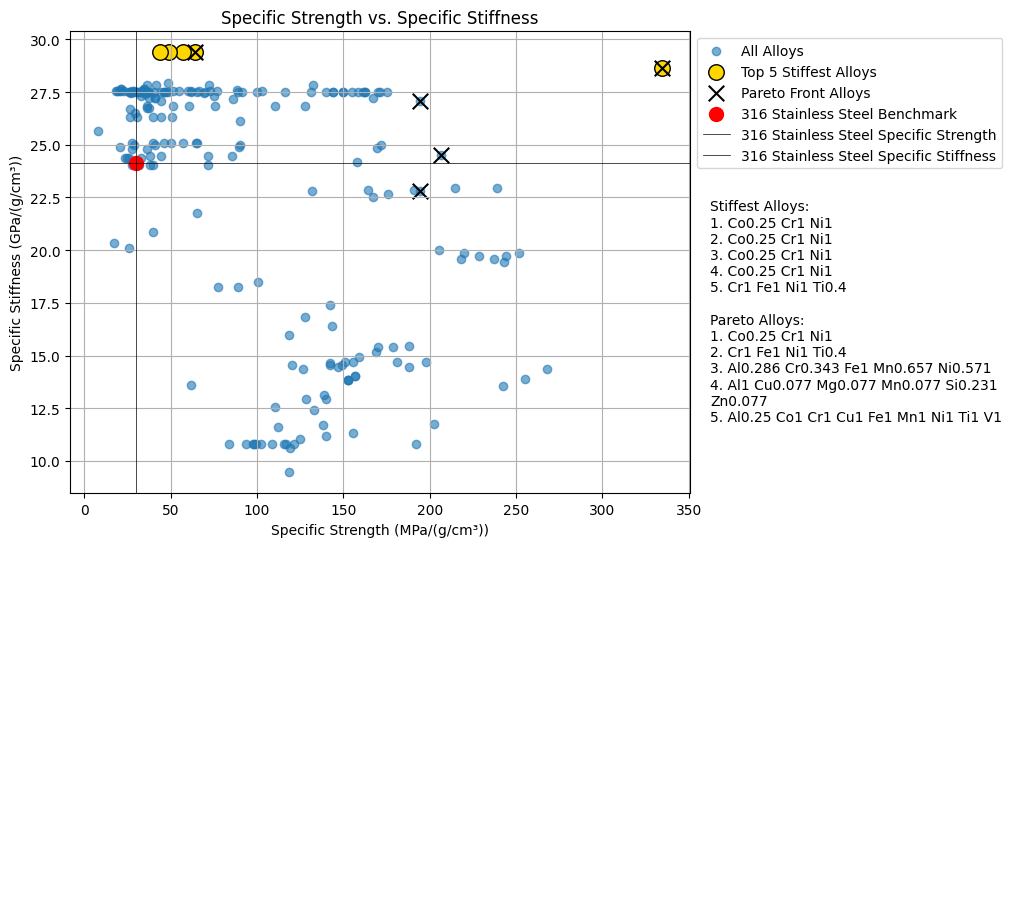

In [85]:
import matplotlib.pyplot as plt

pareto_alloys = pareto_front(df_new, "Specific Strength", "Specific Stiffness", min_points=5)

plt.figure(figsize=(8, 6))

plt.scatter(df_new["Specific Strength"], df_new["Specific Stiffness"], label="All Alloys", alpha=0.6)

plt.scatter(top_stiffness["Specific Strength"], top_stiffness["Specific Stiffness"], color="gold", label="Top 5 Stiffest Alloys", s=125, edgecolors='black')
plt.scatter(pareto_alloys["Specific Strength"], pareto_alloys["Specific Stiffness"], color="black", marker="x", label="Pareto Front Alloys", s=125)

plt.scatter(df_new2["Specific Strength"], df_new2["Specific Stiffness"], color='red', label="316 Stainless Steel Benchmark", s=100)

plt.axvline(x=30, color='black', linestyle='-', linewidth=0.5, label="316 Stainless Steel Specific Strength")
plt.axhline(y=24.125, color='black', linestyle='-', linewidth=0.5, label="316 Stainless Steel Specific Stiffness")

plt.xlabel("Specific Strength (MPa/(g/cm³))")
plt.ylabel("Specific Stiffness (GPa/(g/cm³))")
plt.title("Specific Strength vs. Specific Stiffness")

# Prepare the text for Stiffest Alloys and Pareto Alloys
stiffest_alloys_text = "\n".join([f"{i+1}. {f}" for i, f in enumerate(top_stiffness["FORMULA"].values)])
pareto_alloys_text = "\n".join([f"{i+1}. {f}" for i, f in enumerate(pareto_alloys["FORMULA"].values)])

# Create the text for the plot (with labels for each group)
compositions_text = f"Stiffest Alloys:\n{stiffest_alloys_text}\n\nPareto Alloys:\n{pareto_alloys_text}"

# Adjust legend position and add the compositions text below the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the legend placement
plt.figtext(0.925, 0.6, compositions_text, wrap=True, fontsize=10, ha="left", va="top")  # Place the text below the legend

plt.grid(True)
plt.show()


In [86]:
def pareto_front(df, x_col, y_col, z_col, min_points=5):
    points = df[[x_col, y_col, z_col]].values
    pareto = []

    for i, point in enumerate(points):
        dominated = False
        for j, other in enumerate(points):
            if all(other >= point) and any(other > point):
                dominated = True
                break
        if not dominated:
            pareto.append(i)

    pareto_df = df.iloc[pareto]

    return pareto_df

# Function to compute top 5 Pareto front points prioritizing cost
def top_pareto_front(df, x_col, y_col, z_col):
    pareto_df = pareto_front(df, x_col, y_col, z_col, min_points=5)

    # Sort by cost (ascending) and keep top 5
    top_pareto_df = pareto_df.sort_values(by=z_col, ascending=True).head(5)

    return top_pareto_df

# Compute top 5 Pareto front points prioritizing cost
pareto_alloys1 = top_pareto_front(df_new, "Specific Strength", "Specific Stiffness", "Cost")

In [87]:
def pareto_front(df, x_col, y_col, z_col, a_col, min_points=5):
    points = df[[x_col, y_col, z_col, a_col]].values
    pareto = []

    for i, point in enumerate(points):
        dominated = False
        for j, other in enumerate(points):
            if all(other >= point) and any(other > point):
                dominated = True
                break
        if not dominated:
            pareto.append(i)

    pareto_df = df.iloc[pareto]

    return pareto_df

# Function to compute top 5 Pareto front points prioritizing cost
def top_pareto_front(df, x_col, y_col, z_col, a_col):
    pareto_df = pareto_front(df, x_col, y_col, z_col, a_col, min_points=5)

    # Sort by cost (ascending) and keep top 5
    top_pareto_df = pareto_df.sort_values(by=a_col, ascending=True).head(5)

    return top_pareto_df

# Compute top 5 Pareto front points prioritizing cost
pareto_alloys2 = top_pareto_front(df_new, "Specific Strength", "Specific Stiffness", "PROPERTY: Elongation (%)", "Cost")

In [88]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

x = df_new["Specific Strength"]
y = df_new["Specific Stiffness"]

xmin, xmax = 0, 350
ymin, ymax = 7.5, 30

data2 = {
    "Specific Strength": [30],
    "Specific Stiffness": [24.125],
    "PROPERTY: Elongation (%)": [60],
    "Cost": [5.034346094],
    "FORMULA": ["Fe67.18 Cr17.5 Ni11.5 Mo2.25 Mn1 Si0.5 C0.035 P0.025 S0.01"]
}

df_new2 = pd.DataFrame(data2)

min_size, max_size = 5, 25
sizes = np.interp(df_new["PROPERTY: Elongation (%)"],
                  (df_new["PROPERTY: Elongation (%)"].min(), df_new["PROPERTY: Elongation (%)"].max()),
                  (min_size, max_size))


num_rows_with_zero_cost = (df_new['Cost'] == 0).sum()
print(f"Number of rows with 'Cost' equal to 0: {num_rows_with_zero_cost}")

df_new['Cost Rank'] = df_new['Cost'].rank(method='min')  # Rank costs (1 is the lowest cost, highest rank is the highest cost)

formulas = df_new["FORMULA"]
formulas2 = df_new2["FORMULA"]

# Create 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=x, y=y,
    mode='markers',
    marker=dict(
        size=sizes,  # Use the normalized size from elongation
        color=df_new['Cost Rank'],  # Color by cost
        colorscale='RdYlGn',
        opacity=0.75,
        reversescale=True,
        colorbar=dict(
            title="Cost (USD/kg)",  # Title for the color bar
            tickprefix="$",  # Show cost in dollars
            len=0.4,  # Adjust length of the color bar
            orientation="h",  # Set the color bar to horizontal
            x=1.22,  # Center the color bar horizontally
            y=0.5,  # Move it below the plot
            thickness=16,  # Adjust thickness for better visibility
            title_side="bottom"
        )
    ),
    text=formulas,  # Set the chemical formula as text for each point
    hovertemplate="<b>%{text}</b><br>Strength: %{x} MPa<br>Stiffness: %{y} GPa<br>Cost: %{customdata[1]} USD/kg<br>Elongation: %{customdata[0]}%",
    customdata=df_new[["PROPERTY: Elongation (%)", "Cost"]],
    showlegend=False
)])


fig.add_trace(go.Scatter(
    x=pareto_alloys1["Specific Strength"],
    y=pareto_alloys1["Specific Stiffness"],
    mode='markers',
    marker=dict(
        size=12,  # Size of the markers (can be adjusted)
        color='rgba(0,0,0,0)',  # Transparent fill color
        line=dict(
            color='blue',  # Blue outline color
            width=2  # Width of the outline
        ),
        opacity=1
    ),
    name="Top 5 Pareto Front #3 (Lowest Cost)"
))

fig.add_trace(go.Scatter(
    x=pareto_alloys2["Specific Strength"],
    y=pareto_alloys2["Specific Stiffness"],
    mode='markers',
    marker=dict(
        size=12,  # Size of the markers (can be adjusted)
        color='rgba(0,0,0,0)',  # Transparent fill color
        symbol="x",  # Use "x" symbol for the markers
        line=dict(color="black", width=2),  # Black outline for the "x" symbol
        opacity=1
    ),
    name="Top 5 Pareto Front #4 (Lowest Cost and Elongation %)"
))

# Add 316 Stainless Steel Benchmark
fig.add_trace(go.Scatter(
    x=df_new2["Specific Strength"],
    y=df_new2["Specific Stiffness"],
    mode='markers',
    marker=dict(
        size=12,
        color='red',
        opacity=1
    ),
    text=formulas2,
    hovertemplate="<b>%{text}</b><br>Strength: %{x} MPa<br>Stiffness: %{y} GPa<br>Cost: %{customdata[1]} USD/kg<br>Elongation: %{customdata[0]}%",
    customdata=df_new2[["PROPERTY: Elongation (%)","Cost"]],
    name="316 Stainless Steel Benchmark"
))

# Add vertical and horizontal lines at the specific point (30, 24.125)
fig.add_trace(go.Scatter(
    x=[30, 30],  # x-value for vertical line (fixed at x=30)
    y=[ymin, ymax],  # Span from ymin to ymax on the y-axis
    mode='lines',
    line=dict(color='black'),
    opacity=0.5,
    name="316 Stainless Steel Specific Strength"
))

fig.add_trace(go.Scatter(
    x=[xmin, xmax],  # Start from x=0 to the max value of the x-axis
    y=[24.125, 24.125],  # y-value for horizontal line
    mode='lines',
    line=dict(color='black'),
    opacity=0.5,
    name="316 Stainless Steel Specific Stiffness"
))

pareto_alloys1_text = "<br>".join([f"{i+1}. {f}" for i, f in enumerate(pareto_alloys1["FORMULA"].values)])
pareto_alloys2_text = "<br>".join([f"{i+1}. {f}" for i, f in enumerate(pareto_alloys2["FORMULA"].values)])
compositions_text = f"Pareto Alloys #3:<br>{pareto_alloys1_text}<br><br>Pareto Alloys #4:<br>{pareto_alloys2_text}"

fig.update_layout(
    title="Specific Strength vs. Specific Stiffness",
    xaxis_title="Specific Strength (MPa/(g/cm³))",
    yaxis_title="Specific Stiffness (GPa/(g/cm³))",
    showlegend=True,
    annotations=[
        dict(
            x=1.35, y=-0.1,
            xref="paper", yref="paper",
            text=compositions_text,
            showarrow=False,
            font=dict(size=12, color="black"),
            align="left",
        )],
    xaxis=dict(
        range=[xmin, xmax]  # Set the x-axis limits
    ),
    yaxis=dict(
        range=[ymin, ymax]
))


# Show interactive plot
fig.show()

Number of rows with 'Cost' equal to 0: 0


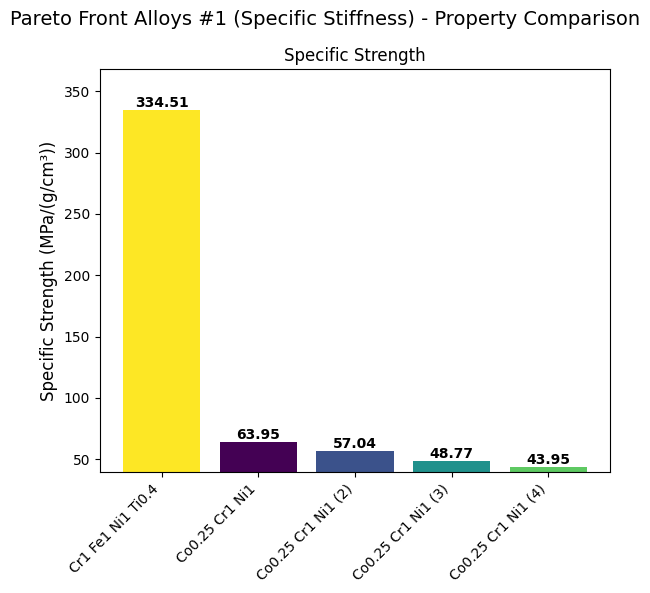

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Define properties, units, and data
pareto_properties = ["Specific Strength"]
property_units = {"Specific Strength": "MPa/(g/cm³)"}
formulas = top_stiffness["FORMULA"].astype(str)  # Ensure formulas are strings

# Count occurrences of duplicate compositions and make them unique
formula_counts = {}
unique_formulas = []
for formula in formulas:
    if formula in formula_counts:
        formula_counts[formula] += 1
        unique_formulas.append(f"{formula} ({formula_counts[formula]})")
    else:
        formula_counts[formula] = 1
        unique_formulas.append(formula)

# Set color map for distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_formulas)))

# Set up the figure
fig, ax = plt.subplots(figsize=(6, 6))  # Square figure

# Get property values
prop = pareto_properties[0]
values = top_stiffness[prop]

# Sort values and formulas together
sorted_indices = np.argsort(values)[::-1]  # Sort in descending order
sorted_values = values.iloc[sorted_indices]
sorted_formulas = np.array(unique_formulas)[sorted_indices]  # Convert to NumPy array

# Assign colors based on sorted order
sorted_colors = [colors[j] for j in sorted_indices]

# Create numerical x positions to remove spacing
x_positions = np.arange(len(sorted_formulas))  # Ensures bars are closely packed

# Plot bars with **tight spacing**
bars = ax.bar(x_positions, sorted_values, color=sorted_colors, width=0.8, align='center')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Set title and labels with units
ax.set_title(prop, fontsize=12)
ax.set_xticks(x_positions)  # Align tick marks with bar positions
ax.set_xticklabels(sorted_formulas, rotation=45, ha='right', fontsize=10)
ax.set_ylabel(f"{prop} ({property_units[prop]})", fontsize=12)

# Adjust y-axis limits dynamically
ax.set_ylim(min(sorted_values) * 0.9, max(sorted_values) * 1.1)

# Adjust layout
fig.suptitle("Pareto Front Alloys #1 (Specific Stiffness) - Property Comparison", fontsize=14)
plt.tight_layout()
plt.show()


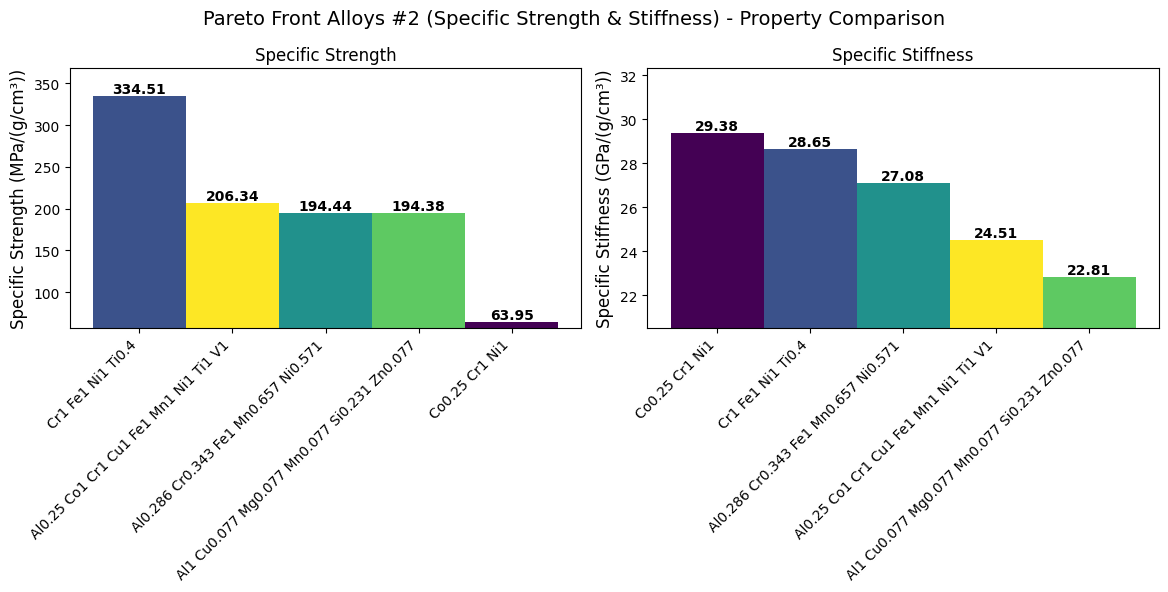

In [90]:


import matplotlib.pyplot as plt
import numpy as np

# Define properties, units, and data
pareto_properties = ["Specific Strength", "Specific Stiffness"]
property_units = {
    "Specific Strength": "MPa/(g/cm³)",
    "Specific Stiffness": "GPa/(g/cm³)",
}
formulas = pareto_alloys["FORMULA"]

# Set color map for distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(formulas)))

# Set up subplots with increased figure size
square_size = 6  # Adjust to control individual subplot size
fig, axes = plt.subplots(1, len(pareto_properties), figsize=(square_size * len(pareto_properties), square_size))

# Adjust spacing between plots
plt.subplots_adjust(wspace=0.4)  # Increase spacing between subplots

# Plot each property separately
for i, prop in enumerate(pareto_properties):
    values = pareto_alloys[prop]

    # Sort values and formulas together
    sorted_indices = np.argsort(values)[::-1]  # Sort in descending order
    sorted_values = values.iloc[sorted_indices]
    sorted_formulas = formulas.iloc[sorted_indices]

    # Assign colors based on sorted order
    sorted_colors = [colors[j] for j in sorted_indices]

    # Plot bars with reduced spacing
    bars = axes[i].bar(sorted_formulas, sorted_values, color=sorted_colors, width=1.0)  # Set width to 1.0

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Set labels and titles with units
    axes[i].set_title(prop, fontsize=12)
    axes[i].set_xticks(np.arange(len(sorted_formulas)))  # Align tick marks
    axes[i].set_xticklabels(sorted_formulas, rotation=45, ha='right', fontsize=10)
    axes[i].set_ylabel(f"{prop} ({property_units[prop]})", fontsize=12)

    # Set dynamic y-axis limits with padding
    axes[i].set_ylim(min(sorted_values) * 0.9, max(sorted_values) * 1.1)

# Set a title and layout adjustments
fig.suptitle("Pareto Front Alloys #2 (Specific Strength & Stiffness) - Property Comparison", fontsize=14)
plt.tight_layout()
plt.show()


<ipython-input-91-8c3416cb2786>:39: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-91-8c3416cb2786>:39: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-91-8c3416cb2786>:39: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



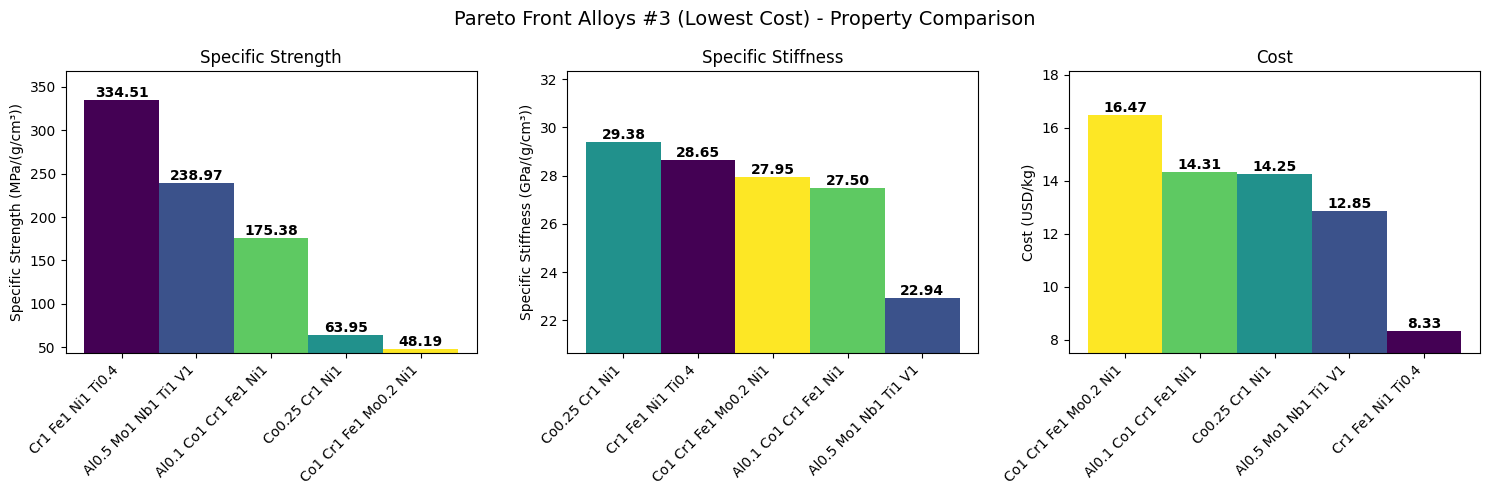

In [91]:


# Define properties, units, and data
pareto_properties = ["Specific Strength", "Specific Stiffness", "Cost"]
property_units = {
    "Specific Strength": "MPa/(g/cm³)",
    "Specific Stiffness": "GPa/(g/cm³)",
    "Cost": "USD/kg"
}
formulas = pareto_alloys1["FORMULA"]

# Set color map for distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(formulas)))

# Set up subplots
fig, axes = plt.subplots(1, len(pareto_properties), figsize=(15, 5))

# Plot each property separately
for i, prop in enumerate(pareto_properties):
    values = pareto_alloys1[prop]

    # Sort values and formulas together
    sorted_indices = np.argsort(values)[::-1]  # Sort in descending order
    sorted_values = values.iloc[sorted_indices]
    sorted_formulas = formulas.iloc[sorted_indices]

    # Assign colors based on sorted order
    sorted_colors = [colors[j] for j in sorted_indices]

    # Plot bars with reduced spacing
    bars = axes[i].bar(sorted_formulas, sorted_values, color=sorted_colors, width=1.0)  # Set width to 1.0

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Set labels and titles with units
    axes[i].set_title(prop)
    axes[i].set_xticklabels(sorted_formulas, rotation=45, ha='right')
    axes[i].set_ylabel(f"{prop} ({property_units[prop]})")

    # Set dynamic y-axis limits with padding
    axes[i].set_ylim(min(sorted_values) * 0.9, max(sorted_values) * 1.1)

fig.suptitle("Pareto Front Alloys #3 (Lowest Cost) - Property Comparison", fontsize=14)
plt.tight_layout()
plt.show()



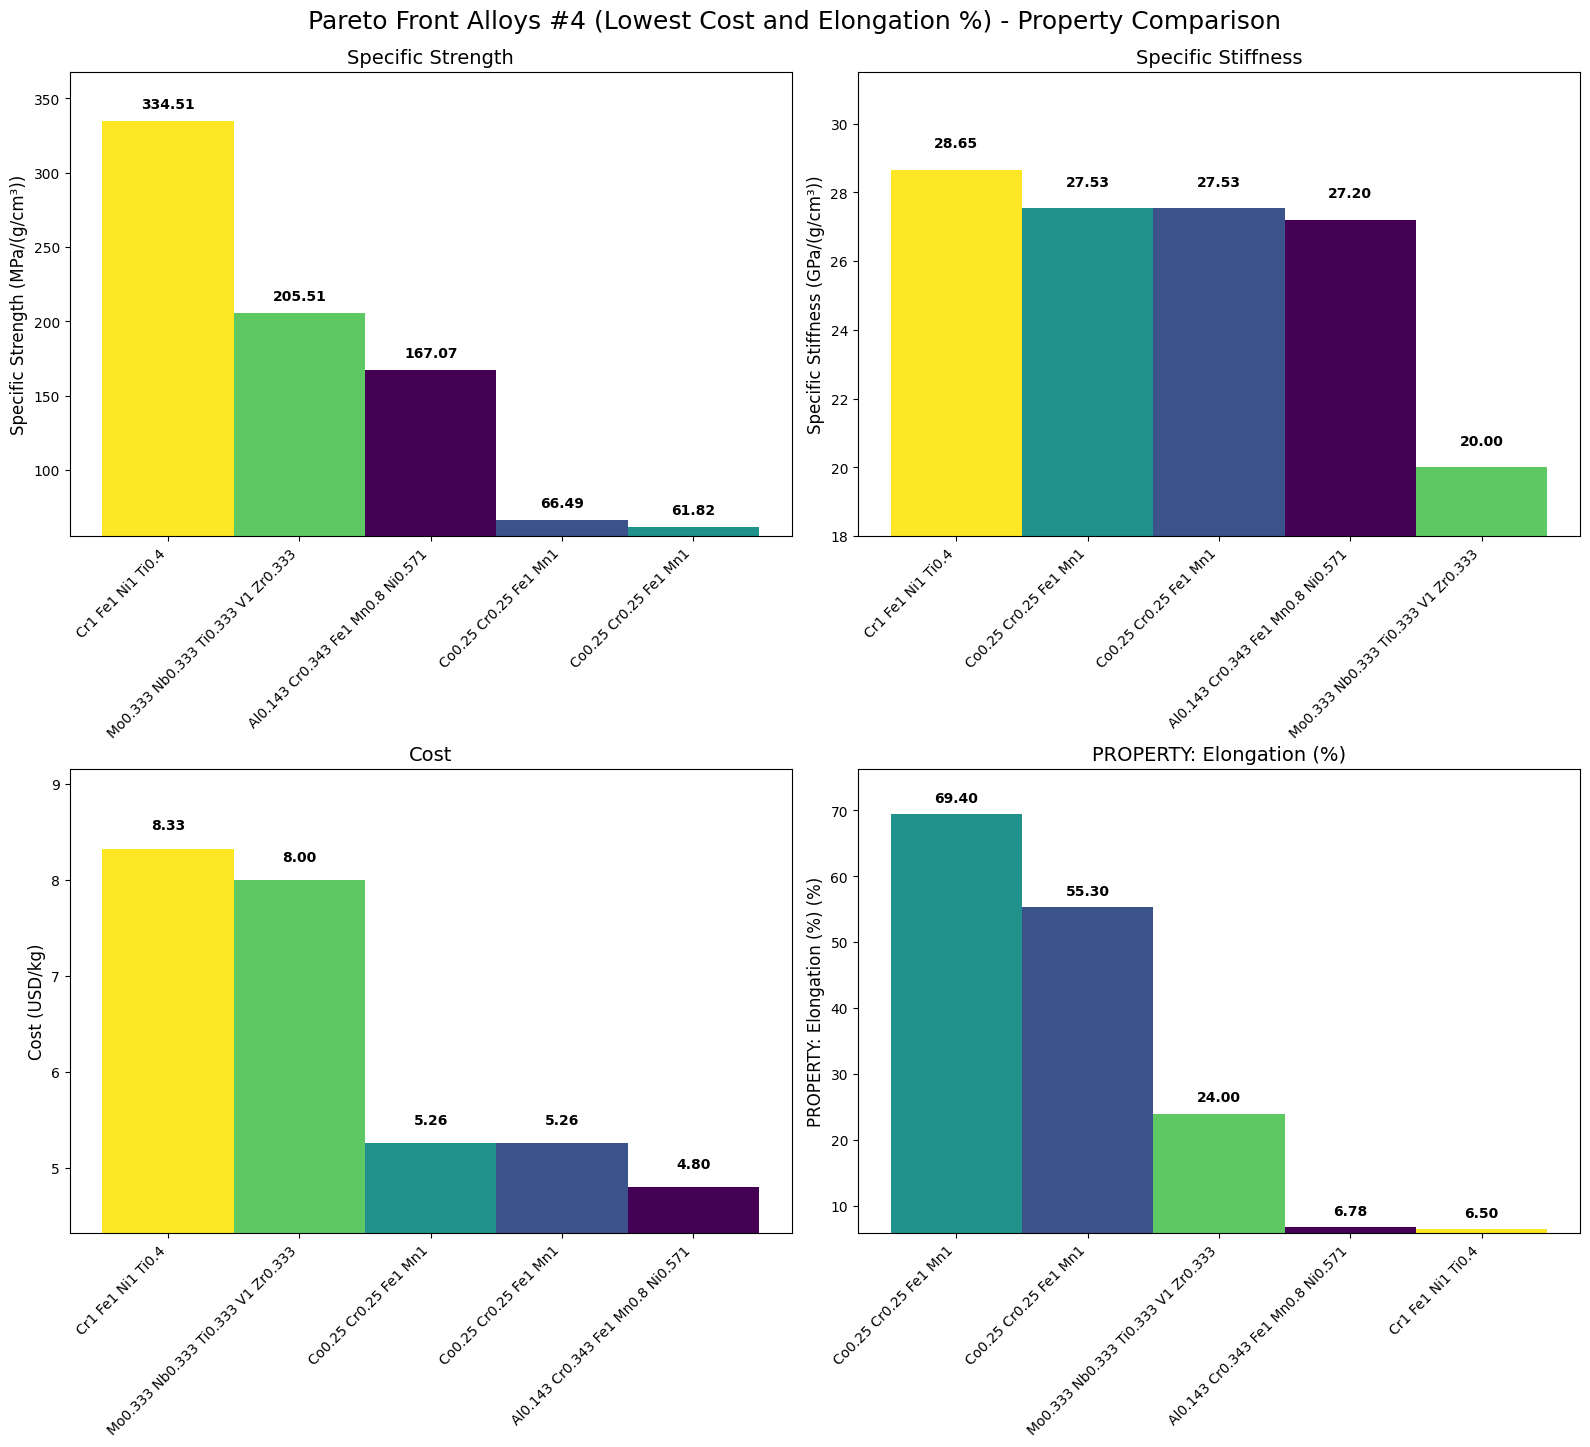

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Define properties, units, and data
pareto_properties = ["Specific Strength", "Specific Stiffness", "Cost", "PROPERTY: Elongation (%)"]
property_units = {
    "Specific Strength": "MPa/(g/cm³)",
    "Specific Stiffness": "GPa/(g/cm³)",
    "Cost": "USD/kg",
    "PROPERTY: Elongation (%)": "%"
}
formulas = pareto_alloys2["FORMULA"]

# Set color map for distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(formulas)))

# Create a 2-row, 2-column layout with spacing adjustments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Larger figure size
axes = axes.flatten()  # Flatten for easy looping

# Plot each property separately
for i, prop in enumerate(pareto_properties):
    values = pareto_alloys2[prop]

    # Sort values and formulas together
    sorted_indices = np.argsort(values)[::-1]  # Sort in descending order
    sorted_values = values.iloc[sorted_indices]
    sorted_formulas = formulas.iloc[sorted_indices]

    # Assign colors based on sorted order
    sorted_colors = [colors[j] for j in sorted_indices]

    # Create bar positions with no extra space
    x_pos = range(len(sorted_formulas))  # Ensures bars are tightly packed

    # Plot bars with **no spacing** and **centered properly**
    bars = axes[i].bar(x_pos, sorted_values, color=sorted_colors, width=1.0, align='edge')

    # Annotate each bar with its value
    for bar, value in zip(bars, sorted_values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height + (max(sorted_values) * 0.02),
                     f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Set labels and titles with units
    axes[i].set_title(prop, fontsize=14)
    axes[i].set_ylabel(f"{prop} ({property_units[prop]})", fontsize=12)
    bar_width = bar.get_width()
    # Adjust x-axis ticks for better alignment
    axes[i].set_xticks(x_pos + bar_width / 2)
    axes[i].set_xticklabels(sorted_formulas, rotation=45, ha='right', fontsize=10)

    # Set dynamic y-axis limits with padding
    axes[i].set_ylim(min(sorted_values) * 0.9, max(sorted_values) * 1.1)

# Adjust layout to push bottom graphs further down and prevent overlapping
plt.tight_layout()
fig.subplots_adjust(bottom=0.0, hspace=0.5)  # Extra spacing for better layout


fig.suptitle("Pareto Front Alloys #4 (Lowest Cost and Elongation %) - Property Comparison", fontsize=18, y=1.02)

# Show the plot
plt.show()


<ipython-input-93-41519852173d>:48: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-93-41519852173d>:48: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-93-41519852173d>:48: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



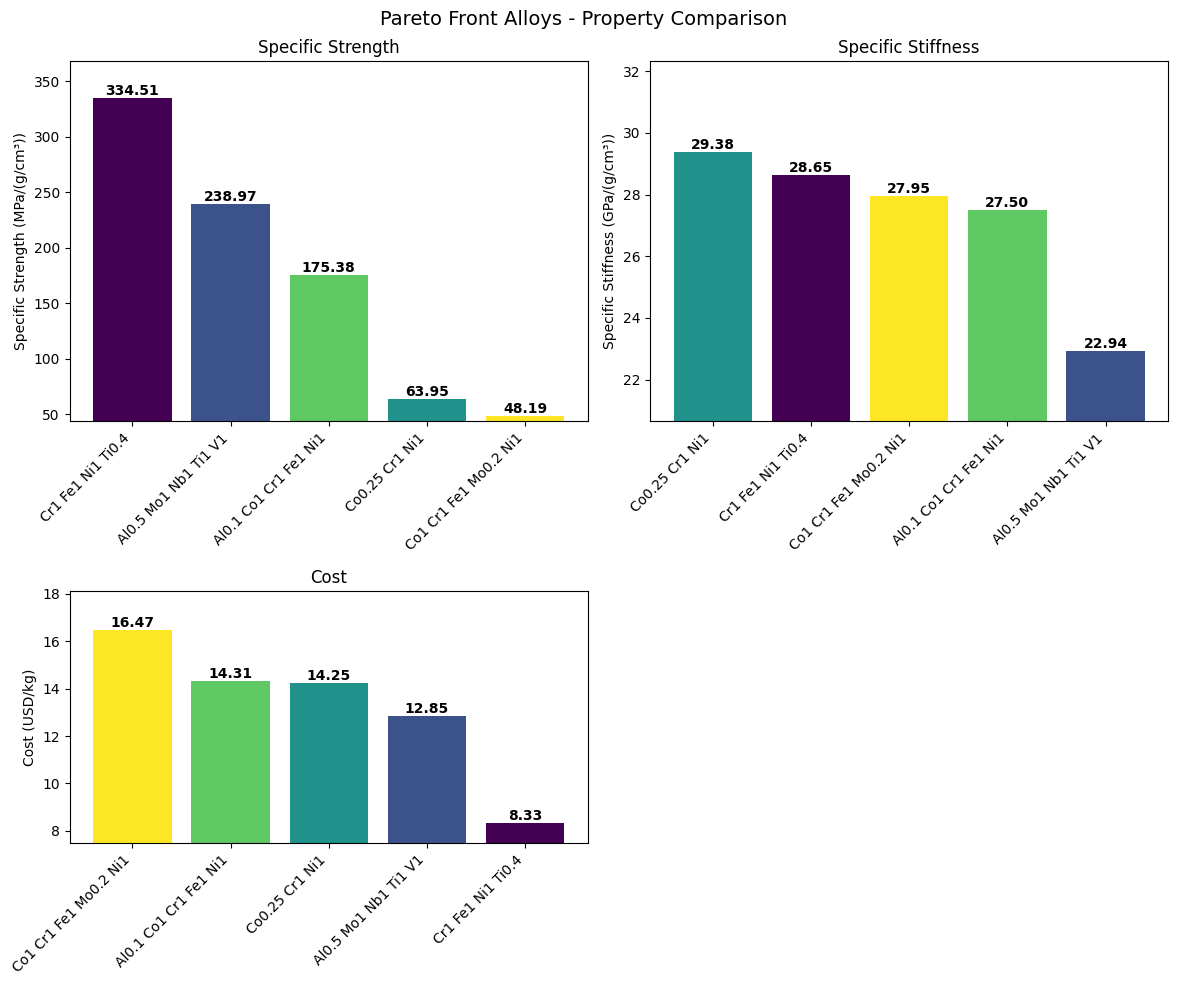

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Define properties, units, and data
pareto_properties = ["Specific Strength", "Specific Stiffness", "Cost"]
property_units = {
    "Specific Strength": "MPa/(g/cm³)",
    "Specific Stiffness": "GPa/(g/cm³)",
    "Cost": "USD/kg"
}
formulas = pareto_alloys1["FORMULA"]

# Set color map for distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(formulas)))

# Create a 2-row, 2-column layout (Cost will be placed below the first row)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 0.7]})

# Flatten axes for easier indexing
axes = axes.flatten()

# Define property placement: First two in row 1, third in row 2, centered
property_positions = [(0, "Specific Strength"), (1, "Specific Stiffness"), (2, "Cost")]

# Plot each property
for i, (ax_idx, prop) in enumerate(property_positions):
    values = pareto_alloys1[prop]

    # Sort values and formulas together
    sorted_indices = np.argsort(values)[::-1]  # Sort in descending order
    sorted_values = values.iloc[sorted_indices]
    sorted_formulas = formulas.iloc[sorted_indices]

    # Assign colors based on sorted order
    sorted_colors = [colors[j] for j in sorted_indices]

    # Plot bars with reduced spacing
    bars = axes[ax_idx].bar(sorted_formulas, sorted_values, color=sorted_colors, width=0.8)

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        axes[ax_idx].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
                          ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Set labels and titles with units
    axes[ax_idx].set_title(prop)
    axes[ax_idx].set_xticklabels(sorted_formulas, rotation=45, ha='right')
    axes[ax_idx].set_ylabel(f"{prop} ({property_units[prop]})")

    # Set dynamic y-axis limits with padding
    axes[ax_idx].set_ylim(min(sorted_values) * 0.9, max(sorted_values) * 1.1)

# Hide the empty subplot (since we only have 3 properties in a 2x2 grid)
fig.delaxes(axes[3])

fig.suptitle("Pareto Front Alloys - Property Comparison", fontsize=14)
plt.tight_layout()
plt.show()


In [94]:
import plotly.graph_objects as go
import numpy as np

top_pareto_alloys = pareto_alloys2
# Example data (replace with your df_new and top_pareto_alloys data)
x = df_new["Specific Strength"]
y = df_new["Specific Stiffness"]
z = df_new["Cost"]
a = df_new["PROPERTY: Elongation (%)"]

# Normalize "PROPERTY: Elongation (%)" for size scaling
min_size, max_size = 5, 30  # Define the visual range for marker size (adjust these values)
sizes = np.interp(df_new["PROPERTY: Elongation (%)"],
                  (df_new["PROPERTY: Elongation (%)"].min(), df_new["PROPERTY: Elongation (%)"].max()),
                  (min_size, max_size))

# Normalize cost for color mapping
colors = df_new["Cost"]

formulas = df_new["FORMULA"]

# Create 3D scatter plot with fixed size scaling
fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=sizes,  # Use the normalized size from elongation
        color=colors,  # Color by cost
        colorscale='Viridis',  # Use a valid color scale like 'Viridis'
        opacity=0.7
    ),
    text=formulas,  # Set the chemical formula as text for each point
    hovertemplate="<b>%{text}</b><br>Strength: %{x} MPa<br>Stiffness: %{y} GPa<br>Cost: %{z} USD/kg<br>Elongation: %{customdata[0]}%",
    customdata=df_new[["PROPERTY: Elongation (%)"]],
)])

# Add Pareto front alloys as gold spheres
fig.add_trace(go.Scatter3d(
    x=top_pareto_alloys["Specific Strength"],
    y=top_pareto_alloys["Specific Stiffness"],
    z=top_pareto_alloys["Cost"],
    mode='markers',
    marker=dict(
        size=12,  # Larger size for Pareto front alloys
        color='gold',
        opacity=1
    ),
    text=formulas,
    hovertemplate="<b>%{text}</b><br>Strength: %{x} MPa<br>Stiffness: %{y} GPa<br>Cost: %{z} USD/kg<br>Elongation: %{customdata[0]}%",
    customdata=df_new[["PROPERTY: Elongation (%)"]],
    name="Top 5 Pareto Front (Lowest Cost)"
))

# Update layout with axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='Specific Strength (MPa/(g/cm³))',
        yaxis_title='Specific Stiffness (GPa/(g/cm³))',
        zaxis_title='Cost (USD/kg)',
    ),
    title="Interactive 3D Pareto Front Analysis",
    showlegend=True
)

# Show interactive plot
fig.show()


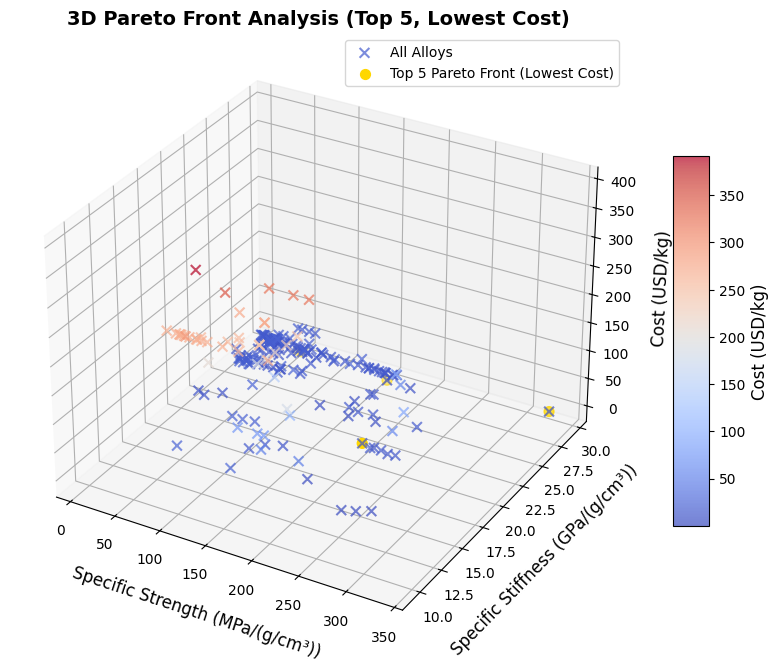

In [95]:
# changed function here


# Function to compute Pareto front
def pareto_front(df, x_col, y_col, z_col, a_col, min_points=5):
    points = df[[x_col, y_col, z_col, a_col]].values
    pareto = []

    for i, point in enumerate(points):
        dominated = False
        for j, other in enumerate(points):
            if all(other >= point) and any(other > point):
                dominated = True
                break
        if not dominated:
            pareto.append(i)

    pareto_df = df.iloc[pareto]

    return pareto_df

# Function to compute top 5 Pareto front points prioritizing cost
def top_pareto_front(df, x_col, y_col, z_col, a_col):
    pareto_df = pareto_front(df, x_col, y_col, z_col, a_col, min_points=5)

    # Sort by cost (ascending) and keep top 5
    top_pareto_df = pareto_df.sort_values(by=a_col, ascending=True).head(5)

    return top_pareto_df

# Compute top 5 Pareto front points prioritizing cost
top_pareto_alloys = top_pareto_front(df_new, "Specific Strength", "Specific Stiffness", "PROPERTY: Elongation (%)", "Cost")

# Create a 3D Scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all alloys with a colormap
sc = ax.scatter(df_new["Specific Strength"], df_new["Specific Stiffness"], df_new["Cost"],
                c=df_new["Cost"], cmap="coolwarm", alpha=0.7, marker="x", s=50, label="All Alloys")


# Plot top 5 Pareto front alloys prioritizing cost distinctly
ax.scatter(top_pareto_alloys["Specific Strength"], top_pareto_alloys["Specific Stiffness"], top_pareto_alloys["Cost"],
           color="gold", s=50, marker="o", label="Top 5 Pareto Front (Lowest Cost)")

# Labels and title
ax.set_xlabel("Specific Strength (MPa/(g/cm³))", fontsize=12, labelpad=10)
ax.set_ylabel("Specific Stiffness (GPa/(g/cm³))", fontsize=12, labelpad=10)
ax.set_zlabel("Cost (USD/kg)", fontsize=12, labelpad=10)
ax.set_title("3D Pareto Front Analysis (Top 5, Lowest Cost)", fontsize=14, fontweight="bold")

# Improve visibility with grid, legend, and color bar
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, aspect=10)
cbar.set_label("Cost (USD/kg)", fontsize=12)

# Show plot
plt.show()


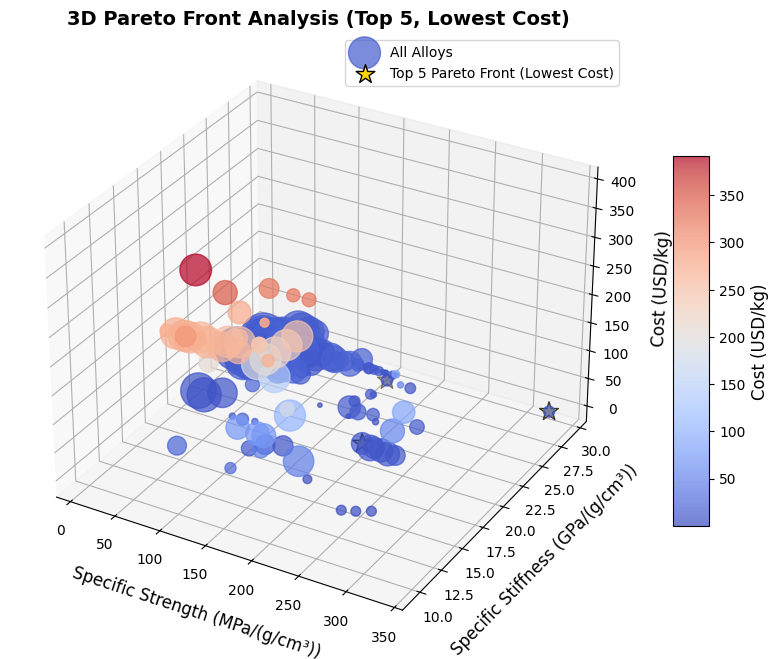

In [96]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize Elongation for better scaling of point sizes
size_scale = df_new["PROPERTY: Elongation (%)"] * 10  # Adjust multiplier if needed

# Scatter plot for all alloys with color = Cost, size = Elongation
sc = ax.scatter(df_new["Specific Strength"], df_new["Specific Stiffness"], df_new["Cost"],
                c=df_new["Cost"], cmap="coolwarm", alpha=0.7, marker="o", s=size_scale, label="All Alloys")

# Plot top 5 Pareto front alloys (distinct marker)
ax.scatter(top_pareto_alloys["Specific Strength"], top_pareto_alloys["Specific Stiffness"], top_pareto_alloys["Cost"],
           c="gold", s=200, marker="*", edgecolors="black", label="Top 5 Pareto Front (Lowest Cost)")

# Labels and title
ax.set_xlabel("Specific Strength (MPa/(g/cm³))", fontsize=12, labelpad=10)
ax.set_ylabel("Specific Stiffness (GPa/(g/cm³))", fontsize=12, labelpad=10)
ax.set_zlabel("Cost (USD/kg)", fontsize=12, labelpad=10)
ax.set_title("3D Pareto Front Analysis (Top 5, Lowest Cost)", fontsize=14, fontweight="bold")

# Improve visibility with grid, legend, and color bar
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, aspect=10)
cbar.set_label("Cost (USD/kg)", fontsize=12)

# Show plot
plt.show()


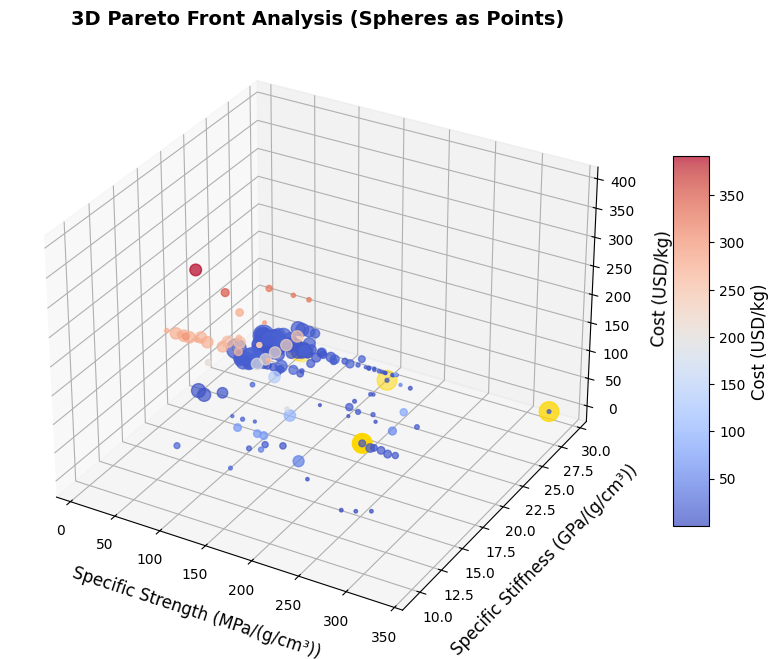

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize "PROPERTY: Elongation (%)" values for sphere sizes
min_size, max_size = 0.2, 1.5  # Min/max sphere sizes
sizes = np.interp(df_new["PROPERTY: Elongation (%)"],
                  (df_new["PROPERTY: Elongation (%)"].min(), df_new["PROPERTY: Elongation (%)"].max()),
                  (min_size, max_size))

# Normalize cost for color mapping
norm = plt.Normalize(df_new["Cost"].min(), df_new["Cost"].max())
cmap = plt.get_cmap("coolwarm")

# Scatter plot for 3D points (spheres)
sc = ax.scatter(df_new["Specific Strength"],
                df_new["Specific Stiffness"],
                df_new["Cost"],
                c=df_new["Cost"],  # Color by cost
                cmap=cmap,
                s=sizes**2 * 100,  # Adjust sphere size based on elongation, scale it for better visibility
                alpha=0.7,
                marker="o",  # Use circle marker to represent spheres
                label="All Alloys")

# Plot top 5 Pareto front alloys distinctly
ax.scatter(top_pareto_alloys["Specific Strength"],
           top_pareto_alloys["Specific Stiffness"],
           top_pareto_alloys["Cost"],
           color="gold",
           s=200,  # Fixed larger size for Pareto front alloys
           label="Top 5 Pareto Front (Lowest Cost)",
           marker="o")

# Labels and title
ax.set_xlabel("Specific Strength (MPa/(g/cm³))", fontsize=12, labelpad=10)
ax.set_ylabel("Specific Stiffness (GPa/(g/cm³))", fontsize=12, labelpad=10)
ax.set_zlabel("Cost (USD/kg)", fontsize=12, labelpad=10)
ax.set_title("3D Pareto Front Analysis (Spheres as Points)", fontsize=14, fontweight="bold")

# Add a colorbar to show cost mapping
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, aspect=10)
cbar.set_label("Cost (USD/kg)", fontsize=12)

# Show plot
plt.show()
